#Librerías

In [72]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
#Librerías
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats 

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

import lightgbm as lgb
import xgboost as xgb
from catboost.core import CatBoostClassifier
import catboost as cb

import warnings
warnings.filterwarnings('ignore')

#Datos

- **Link de Kaggle con los modelos (usado de guía):** https://www.kaggle.com/code/samratp/lightgbm-xgboost-catboost/notebook#Catboost 

- **Link Paper con códigos (usado de guía):** https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db 

- **Link del Dataset utilizado en Kaggle:** https://www.kaggle.com/datasets/jillanisofttech/diabetes-disease-updated-dataset?resource=download&select=diabetes.csv 


##Análisis Exploratorio

In [74]:
#Leer archivo
datos = pd.read_csv('Diabetes.csv')

In [75]:
#Dimensiones del dataframe
datos.shape

(768, 9)

In [76]:
#Mostrar los datos
datos.sample(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
681,0,162,76,36,0,49.6,0.364,26,1
371,0,118,64,23,89,0.0,1.731,21,0
660,10,162,84,0,0,27.7,0.182,54,0
526,1,97,64,19,82,18.2,0.299,21,0
606,1,181,78,42,293,40.0,1.258,22,1
361,5,158,70,0,0,29.8,0.207,63,0
756,7,137,90,41,0,32.0,0.391,39,0
11,10,168,74,0,0,38.0,0.537,34,1
581,6,109,60,27,0,25.0,0.206,27,0
267,2,128,64,42,0,40.0,1.101,24,0


In [77]:
#Información de los datos
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [78]:
#Tipos de datos
datos.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [79]:
#Obtener información estadística de las variables cuantitativas
datos.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


##Pre-Procesamiento

###Datos Vacíos

In [80]:
#Obtener la cantidad de datos vacíos
datos.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [81]:
#Obtener la proporción/ratio de datos vacíos
ratio = ((datos.isnull().sum() / len(datos)) * 100)
print(ratio)

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64


###Prueba de normalidad
- Ho: la variable se aproxima a una distribución normal
- Ha: la variable no se aproxima a una distribución normal

- Si el pvalor =< 5% => Se rechaza la Ho, al 95% de confianza, las variable no se aproxima a una distribución normal

- Si el pvalor > 5% => No se rechaza la Ho, al 95% de confianza, las variable se aproxima a una distribución normal

In [82]:
#Obtener las variables numéricas
normalidad = datos.select_dtypes(include = [np.float64, np.int64])

In [83]:
#Variables que no siguen una distribución normal
for i in normalidad:
  stats, p_value = ss.shapiro(normalidad[i])
  
  if p_value <= 0.05:
    print("No Distribución normal:  ", i, " => ", p_value)

No Distribución normal:   Pregnancies  =>  1.6080885881590613e-21
No Distribución normal:   Glucose  =>  1.9867612763291298e-11
No Distribución normal:   BloodPressure  =>  1.5840069624449098e-28
No Distribución normal:   SkinThickness  =>  1.75157635361056e-21
No Distribución normal:   Insulin  =>  7.915248149269491e-34
No Distribución normal:   BMI  =>  1.8405621485603632e-15
No Distribución normal:   DiabetesPedigreeFunction  =>  2.477696547502535e-27
No Distribución normal:   Age  =>  2.401946561183188e-24
No Distribución normal:   Outcome  =>  1.2922618893873923e-38


In [84]:
#Variables que siguen una distribución normal
for i in normalidad:
  stats, p_value = ss.shapiro(normalidad[i])
  if p_value >= 0.05:
    print("Distribución normal: ", i, " => ", p_value)

Ninguna de las variables sigue una distribución normal

###Correlación de datos
- Si las variables se aproximan a una distribución normal => Pearson
- Si las variables no se aproximan a una distribución normal => Spearman

In [85]:
correlacion = datos.copy()

####Heatmap

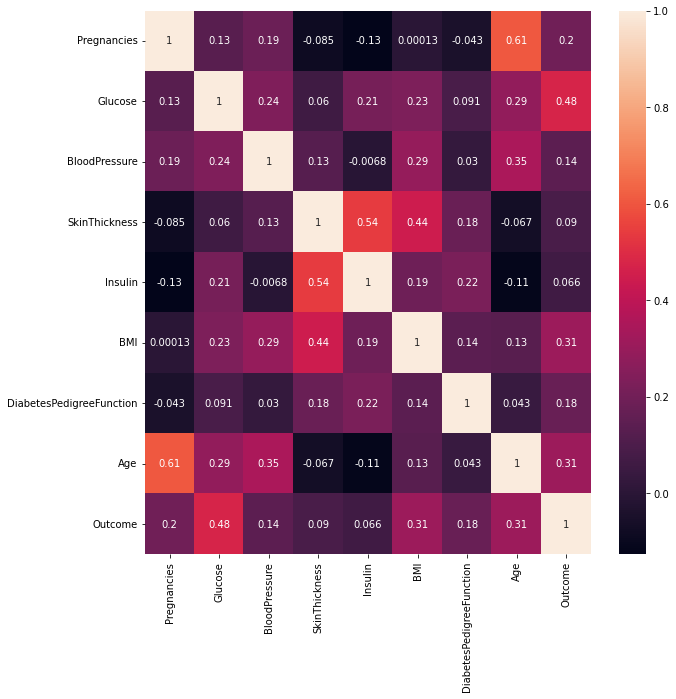

In [86]:
plt.figure(figsize = (10,10))
sns.heatmap(correlacion.corr(method = 'spearman'), annot = True)
plt.show()

En base al heatmap, se puede observar que las variables que parecen tener algún tipo de correlación son:
- Age con Pregnancies
- Insulin con Skin Thickness

####Matriz de correlación

In [87]:
#Prueba de Spearman
ss.spearmanr(datos['Age'], datos['Pregnancies'])

SpearmanrResult(correlation=0.6072163388236559, pvalue=1.4541422344057867e-78)

En base a la prueba de Spearman se puede corroborar que hay una ligera correlación directa entre Age y Pregnancies con un valor de correlación de 0.61 aprox.

In [88]:
#Prueba de Spearman
ss.spearmanr(datos['Insulin'], datos['SkinThickness'])

SpearmanrResult(correlation=0.5410001366628013, pvalue=1.3420383496117887e-59)

En base a la prueba de spearman se puede determinar que hay una ligera correlación directa entre Insulin y SkinThickness ya que su valor de correlación es de 0.54 aprox, que es algo bajo.

#Preparación de Datos para los Modelos

In [89]:
 #Datos del modelo
 Datos_Modelos = datos.copy()

In [90]:
#Seleccionar datos para el modelo
X = Datos_Modelos.iloc[:,[0,1,2,3,4,5,6,7]].values
y = Datos_Modelos['Outcome']

In [91]:
#Datos de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

#LightGBM

In [92]:
#Crear modelo
modelo_LGBM = lgb.LGBMClassifier(silent=False)

In [93]:
#Tuning
parametros3 = {"max_depth": [25,50, 75],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [200]
             }

In [94]:
#Buscar los mejores parámetros
grid = GridSearchCV(modelo_LGBM, param_grid = parametros3, cv = 3, scoring="roc_auc", verbose=5)
grid.fit(X_train,y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END learning_rate=0.01, max_depth=25, n_estimators=200, num_leaves=300;, score=0.799 total time=   0.1s
[CV 2/3] END learning_rate=0.01, max_depth=25, n_estimators=200, num_leaves=300;, score=0.837 total time=   0.1s
[CV 3/3] END learning_rate=0.01, max_depth=25, n_estimators=200, num_leaves=300;, score=0.771 total time=   0.1s
[CV 1/3] END learning_rate=0.01, max_depth=25, n_estimators=200, num_leaves=900;, score=0.799 total time=   0.1s
[CV 2/3] END learning_rate=0.01, max_depth=25, n_estimators=200, num_leaves=900;, score=0.837 total time=   0.1s
[CV 3/3] END learning_rate=0.01, max_depth=25, n_estimators=200, num_leaves=900;, score=0.771 total time=   0.1s
[CV 1/3] END learning_rate=0.01, max_depth=25, n_estimators=200, num_leaves=1200;, score=0.799 total time=   0.1s
[CV 2/3] END learning_rate=0.01, max_depth=25, n_estimators=200, num_leaves=1200;, score=0.837 total time=   0.1s
[CV 3/3] END learning_rate=0.01, 

GridSearchCV(cv=3, estimator=LGBMClassifier(silent=False),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [25, 50, 75], 'n_estimators': [200],
                         'num_leaves': [300, 900, 1200]},
             scoring='roc_auc', verbose=5)

In [95]:
#Mostrar los mejores parámetros
print(grid.best_estimator_)

LGBMClassifier(learning_rate=0.01, max_depth=25, n_estimators=200,
               num_leaves=300, silent=False)


In [96]:
#Crear modelo con los mejores parámetros
modelo_LGBM = lgb.LGBMClassifier(learning_rate=0.01, max_depth=25, n_estimators=200, num_leaves=300, silent=False).fit(X_train, y_train)

In [97]:
#Verificar las predicciones
y_pred = modelo_LGBM.predict(X_test)

Confusion matrix, without normalization
[[93 14]
 [16 31]]
Normalized confusion matrix
[[0.86915888 0.13084112]
 [0.34042553 0.65957447]]


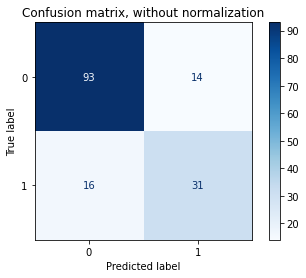

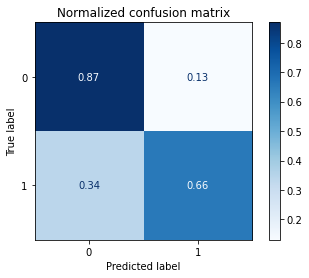

In [98]:
#Matriz de confusión
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(modelo_LGBM, X_test, y_test,
                                 #display_labels=y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [99]:
#Probabilidad de las predicciones
y_pred_prob = modelo_LGBM.predict_proba(X_test)

In [100]:
#Falsos positivos, Verdaderos positivos
false_positive_rate_LGBM, true_positive_rate_LGBM, thresholds = roc_curve(y_test, y_pred_prob[:,1])

In [101]:
#Curva ROC
ROC_LGBM = auc(false_positive_rate_LGBM, true_positive_rate_LGBM)
ROC_LGBM

0.8490753628952078

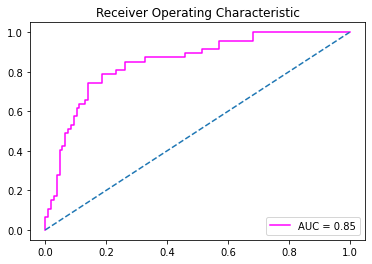

In [102]:
#Mostrar curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_LGBM,true_positive_rate_LGBM, color='magenta',label = 'AUC = %0.2f' % ROC_LGBM)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.show()

#XGBoost

In [103]:
#Crear modelo
modelXGB = xgb.XGBClassifier()

In [104]:
#Tuning
parametros = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.01, 0.1,0.2],}

In [105]:
#Buscar los mejores parámetros
grid = GridSearchCV(modelXGB, param_grid=parametros, cv = 3, verbose=2)
grid.fit(X_train,y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=200; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=200; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=200; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=6, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=6, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=6, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=

GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [10, 30, 50],
                         'min_child_weight': [1, 3, 6], 'n_estimators': [200]},
             verbose=2)

In [106]:
#Mostrar los mejores parámetros
print(grid.best_estimator_)

XGBClassifier(learning_rate=0.01, max_depth=10, min_child_weight=6,
              n_estimators=200)


In [107]:
#Construir el modelo con los mejores parámetros
modelXGB = xgb.XGBClassifier(max_depth = 10, min_child_weight = 6, n_estimators = 200, learning_rate = 0.01, verbose = 2).fit(X_train, y_train)

In [108]:
#Predicciones
y_pred = modelXGB.predict(X_test)

Confusion matrix, without normalization
[[95 12]
 [13 34]]
Normalized confusion matrix
[[0.88785047 0.11214953]
 [0.27659574 0.72340426]]


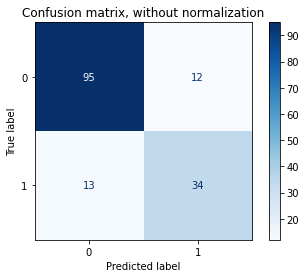

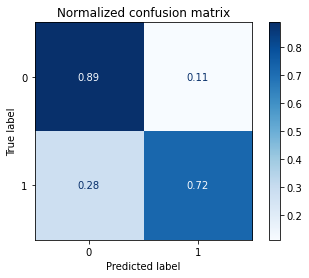

In [109]:
#Matriz de Confusión
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(modelXGB, X_test, y_test,
                                 #display_labels=y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [110]:
#Probabilidades de predicciones
y_pred_prob = modelXGB.predict_proba(X_test)

In [111]:
#Falsos positivos, verdaderos positivos
false_positive_rateXGB, true_positive_rateXGB, thresholds = roc_curve(y_test, y_pred_prob[:,1])

In [112]:
#Curva ROC
roc_XGB = auc(false_positive_rateXGB, true_positive_rateXGB)
roc_XGB

0.8528534499900577

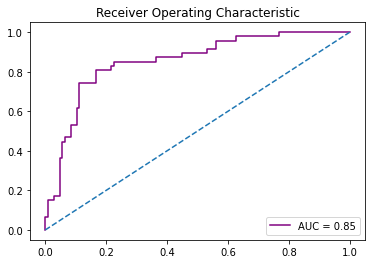

In [113]:
#Mostrar curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rateXGB,true_positive_rateXGB, color='purple',label = 'AUC = %0.2f' % roc_XGB)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.show()

#CatBoost

In [114]:
#Crear modelo
gato = cb.CatBoostClassifier()

In [115]:
#Tuning
parametros2 = {"depth": [1, 5, 10],
          "learning_rate" : [0.03, 0.1, 0.15],
         "l2_leaf_reg": [1,4,9],
         "iterations": [200]}

In [116]:
#Buscar los mejores parámetros
grid = GridSearchCV(gato, param_grid = parametros2, scoring="roc_auc", cv = 3, verbose = 5)
grid.fit(X_train,y_train)

Streaming output truncated to the last 5000 lines.
24:	learn: 0.1444483	total: 253ms	remaining: 1.77s
25:	learn: 0.1376891	total: 263ms	remaining: 1.76s
26:	learn: 0.1329511	total: 273ms	remaining: 1.75s
27:	learn: 0.1269849	total: 283ms	remaining: 1.74s
28:	learn: 0.1222226	total: 293ms	remaining: 1.73s
29:	learn: 0.1171503	total: 303ms	remaining: 1.72s
30:	learn: 0.1138784	total: 315ms	remaining: 1.72s
31:	learn: 0.1099522	total: 337ms	remaining: 1.77s
32:	learn: 0.1065896	total: 347ms	remaining: 1.75s
33:	learn: 0.1023412	total: 356ms	remaining: 1.74s
34:	learn: 0.0975682	total: 366ms	remaining: 1.73s
35:	learn: 0.0917786	total: 376ms	remaining: 1.71s
36:	learn: 0.0881883	total: 386ms	remaining: 1.7s
37:	learn: 0.0839986	total: 396ms	remaining: 1.69s
38:	learn: 0.0820264	total: 407ms	remaining: 1.68s
39:	learn: 0.0790264	total: 417ms	remaining: 1.67s
40:	learn: 0.0765376	total: 427ms	remaining: 1.66s
41:	learn: 0.0737030	total: 438ms	remaining: 1.65s
42:	learn: 0.0716185	total: 448m

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fb490e39cd0>,
             param_grid={'depth': [1, 5, 10], 'iterations': [200],
                         'l2_leaf_reg': [1, 4, 9],
                         'learning_rate': [0.03, 0.1, 0.15]},
             scoring='roc_auc', verbose=5)

In [117]:
#Mostrar los mejores parámetros
print(grid.best_estimator_)


In [118]:
print(grid.best_params_)

{'depth': 1, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.03}


In [119]:
#Crear modelo con los mejores parámetros
modelCatBoost = cb.CatBoostClassifier(eval_metric="AUC", depth=1, iterations= 200, l2_leaf_reg= 1, learning_rate= 0.03).fit(X_train, y_train)

0:	total: 401us	remaining: 80ms
1:	total: 1.53ms	remaining: 151ms
2:	total: 2.2ms	remaining: 145ms
3:	total: 2.85ms	remaining: 140ms
4:	total: 3.44ms	remaining: 134ms
5:	total: 4.04ms	remaining: 131ms
6:	total: 4.64ms	remaining: 128ms
7:	total: 5.24ms	remaining: 126ms
8:	total: 5.85ms	remaining: 124ms
9:	total: 6.44ms	remaining: 122ms
10:	total: 7.06ms	remaining: 121ms
11:	total: 7.66ms	remaining: 120ms
12:	total: 8.24ms	remaining: 119ms
13:	total: 8.84ms	remaining: 117ms
14:	total: 9.46ms	remaining: 117ms
15:	total: 10.1ms	remaining: 116ms
16:	total: 10.7ms	remaining: 115ms
17:	total: 11.3ms	remaining: 114ms
18:	total: 11.9ms	remaining: 113ms
19:	total: 12.5ms	remaining: 113ms
20:	total: 13.1ms	remaining: 112ms
21:	total: 14.1ms	remaining: 114ms
22:	total: 14.7ms	remaining: 113ms
23:	total: 15.3ms	remaining: 112ms
24:	total: 16ms	remaining: 112ms
25:	total: 16.6ms	remaining: 111ms
26:	total: 17.2ms	remaining: 110ms
27:	total: 17.8ms	remaining: 109ms
28:	total: 18.4ms	remaining: 109ms


In [120]:
#Verificar lo predecido
y_pred = modelCatBoost.predict(X_test)

Confusion matrix, without normalization
[[97 10]
 [21 26]]
Normalized confusion matrix
[[0.90654206 0.09345794]
 [0.44680851 0.55319149]]


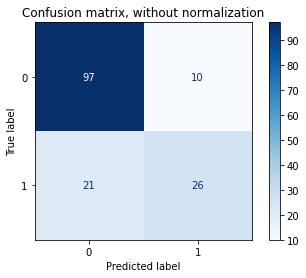

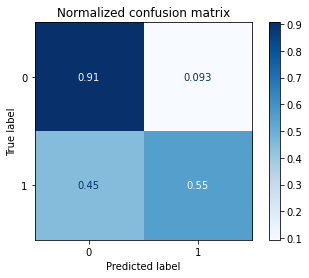

In [121]:
#Matriz de confusión
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(modelCatBoost, X_test, y_test,
                                 #display_labels=y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [122]:
#Probabilidad de lo predecido
y_pred_prob = modelCatBoost.predict_proba(X_test)

In [123]:
#Falsos Positivos, Verdaderos positivos
false_positive_rate_CatBoost, true_positive_rate_CatBoost, thresholds = roc_curve(y_test, y_pred_prob[:,1])

In [124]:
#Curva ROC
ROC_CatBoost = auc(false_positive_rate_CatBoost, true_positive_rate_CatBoost)
ROC_CatBoost

0.8590176973553391

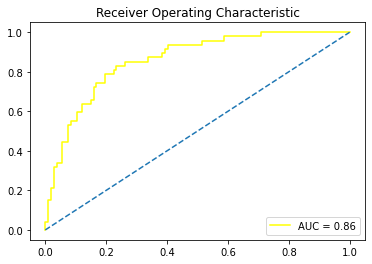

In [125]:
#Mostrar curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_CatBoost,true_positive_rate_CatBoost, color='yellow',label = 'AUC = %0.2f' % ROC_CatBoost)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.show()

#Comparación de modelos

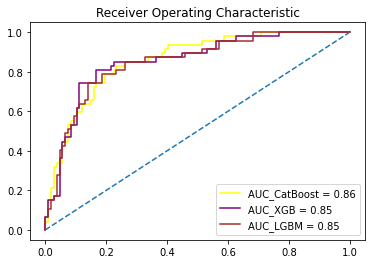

In [126]:
#Mostrar todas las curvas ROC
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_CatBoost,true_positive_rate_CatBoost, color='yellow',label = 'AUC_CatBoost = %0.2f' % ROC_CatBoost)
plt.plot(false_positive_rateXGB,true_positive_rateXGB, color='purple',label = 'AUC_XGB = %0.2f' % roc_XGB)
plt.plot(false_positive_rate_LGBM,true_positive_rate_LGBM, color='brown',label = 'AUC_LGBM = %0.2f' % ROC_LGBM)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.show()

Los valores de las 3 curvas ROC son:
- AUC_CatBoost = 0.86
- AUC_XGB = 0.85
- AUC_LGBM = 0.85

En base a los valores de las curvas AUC, se puede concluir que el mejor modelo fue CatBoost con 0.86 y luego hay un empate entre XGBoost y LightGBM con un AUC de 0.85. Todos los modelos demostraron ser bastante eficaces teniendo valores mayores a 0.80 en su curva ROC.